In [2]:
!pip install librosa


  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/b5/ba/c63c5786dfee4c3417094c4b00966e61e4a63efecee22cb7b4c0387dda83/librosa-0.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for soundfile>=0.12.1 from https://files.pythonhosted.org/packages/14/e9/6b761de83277f2f02ded7e7ea6f07828ec78e4b229b80e4ca55dd205b9dc/soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata
  Obtaining dependency information for pooch>=1.1 from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/packages/86/94/6a7e91bea7e6ca193ee429869b8f18548cd79759e064021ecb5756024c7c/soxr-

In [9]:
import os
import numpy as np
import pandas as pd
import librosa

def generate_audio_feature_csv(input_folder, mfcc_count=40):
    """
    Generate a CSV file containing features extracted from each audio file.
    
    Features included:
    - 40 MFCC coefficients (mean values)
    - RMS Energy
    - Pitch Standard Deviation
    - Zero Crossing Rate
    - Silence Percentage
    - File Name
    - Label (blank for manual assignment)
    
    Parameters:
    input_folder (str): Path to the folder containing audio files (.wav or .mp3)
    mfcc_count (int): Number of MFCC features to extract
    
    Returns:
    pd.DataFrame: DataFrame with all extracted features, saved as a CSV file
    """
    
    feature_rows = []  # Will store features for each file
    
    for audio_file in os.listdir(input_folder):
        if audio_file.lower().endswith(('.wav', '.mp3')):  # Accept WAV and MP3
            full_path = os.path.join(input_folder, audio_file)
            
            try:
                # ---- Load audio ----
                signal, sr = librosa.load(full_path, sr=None)
                
                # ---- 1. MFCC Extraction ----
                mfcc_values = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=mfcc_count)
                mfcc_means = np.mean(mfcc_values, axis=1)
                
                # ---- 2. RMS Energy ----
                rms_energy = float(np.mean(librosa.feature.rms(y=signal)))
                
                # ---- 3. Pitch Standard Deviation ----
                pitches, magnitudes = librosa.piptrack(y=signal, sr=sr)
                pitch_points = pitches[magnitudes > np.median(magnitudes)]
                pitch_std_dev = float(np.std(pitch_points)) if pitch_points.size > 0 else 0.0
                
                # ---- 4. Zero Crossing Rate ----
                zcr_value = float(np.mean(librosa.feature.zero_crossing_rate(y=signal)))
                
                # ---- 5. Silence Percentage ----
                silence_threshold = 0.02
                silent_samples = np.sum(np.abs(signal) < silence_threshold)
                silence_percentage = (silent_samples / len(signal)) * 100
                
                # ---- Combine all features into one row ----
                row = [audio_file] + list(mfcc_means) + [rms_energy, pitch_std_dev, zcr_value, silence_percentage, ""]
                feature_rows.append(row)
            
            except Exception as e:
                print(f"Skipping file {full_path}: {e}")
    
    # ---- Define column names ----
    mfcc_columns = [f"mfcc_{i+1}" for i in range(mfcc_count)]
    all_columns = ["file_name"] + mfcc_columns + ["rms_energy", "pitch_std_dev", "zero_crossing_rate", "silence_percent", "label"]
    
    # ---- Create DataFrame ----
    feature_df = pd.DataFrame(feature_rows, columns=all_columns)
    
    # ---- Save as CSV ----
    output_path = os.path.join(input_folder, "confidence_features.csv")
    feature_df.to_csv(output_path, index=False)
    
    print(f"\n Feature extraction complete!")
    print(f"CSV saved at: {output_path}")
    print(f"Data shape: {feature_df.shape}")
    
    return feature_df

# ---- Run the function ----
audio_folder_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012"
df_features = generate_audio_feature_csv(audio_folder_path)

# ---- Preview first few rows ----
print(df_features.head())



 Feature extraction complete!
CSV saved at: D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features.csv
Data shape: (30, 46)
  file_name      mfcc_1      mfcc_2     mfcc_3     mfcc_4    mfcc_5    mfcc_6  \
0   134.mp3 -425.393433  125.519920  40.010544   8.590043 -9.315612 -4.196269   
1   135.mp3 -382.260406  121.119316  20.482317  20.463820 -0.623395 -1.375018   
2   136.mp3 -418.628418  133.654602  37.156345   7.813893  0.393236  1.303675   
3   137.mp3 -419.574860  130.488800  38.824398   7.156448 -6.441831 -2.545286   
4   138.mp3 -349.586761  139.194321  15.105521   6.653083  5.896433 -8.471100   

      mfcc_7     mfcc_8     mfcc_9  ...   mfcc_36   mfcc_37   mfcc_38  \
0  -6.434660 -13.054656  -6.819299  ... -0.322650 -1.963164 -1.324499   
1  -7.704275 -11.947603  -6.586792  ... -1.064188 -2.694440 -2.007034   
2 -11.833933 -14.132703  -6.178303  ... -2.124747 -3.323396 -2.690340   
3 -10.852737 -13.259617  -5.739337  ... -0.441539 -2.596083 -2.215122   

In [10]:
import os
import numpy as np
import pandas as pd
import librosa

def create_confidence_feature_csv(audio_folder):
    """
    Extracts 5 main audio features from each file and saves them into a CSV:
    - MFCC1 (mean)
    - RMS energy
    - Zero Crossing Rate
    - Pitch standard deviation
    - Silence percentage
    
    Adds columns: filename and class (blank for manual labeling).
    
    Parameters:
        audio_folder (str): Folder path containing audio files (.wav or .mp3)
    
    Returns:
        pandas.DataFrame: DataFrame of extracted features
    """
    
    features_list = []
    
    for file_name in os.listdir(audio_folder):
        if file_name.lower().endswith(('.wav', '.mp3')):
            file_path = os.path.join(audio_folder, file_name)
            
            try:
                # Load audio
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                
                # Feature 1: MFCC1 (average value of first coefficient)
                mfcc_values = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=1)
                mfcc1_avg = float(np.mean(mfcc_values))
                
                # Feature 2: RMS energy
                rms_energy = float(np.mean(librosa.feature.rms(y=audio_data)))
                
                # Feature 3: Zero Crossing Rate
                zcr_avg = float(np.mean(librosa.feature.zero_crossing_rate(y=audio_data)))
                
                # Feature 4: Pitch standard deviation
                pitches, mags = librosa.piptrack(y=audio_data, sr=sample_rate)
                valid_pitches = pitches[mags > np.median(mags)]
                pitch_stddev = float(np.std(valid_pitches)) if valid_pitches.size > 0 else 0.0
                
                # Feature 5: Silence percentage
                silence_threshold = 0.02
                silent_samples = np.sum(np.abs(audio_data) < silence_threshold)
                silence_percentage = (silent_samples / len(audio_data)) * 100
                
                # Append all to list
                row = [file_name, mfcc1_avg, rms_energy, zcr_avg, pitch_stddev, silence_percentage, ""]
                features_list.append(row)
            
            except Exception as err:
                print(f"Error processing {file_path}: {err}")
    
    # Column names
    columns = ["filename", "mfcc1", "rms", "zcr", "pitch_std", "silence_pc", "class"]
    
    # Create DataFrame
    df_features = pd.DataFrame(features_list, columns=columns)
    
    # Save CSV with required name
    output_file = os.path.join(audio_folder, "confidence_features(1).csv")
    df_features.to_csv(output_file, index=False)
    
    print(f"\n CSV successfully saved as: {output_file}")
    print(f"Shape: {df_features.shape}")
    
    return df_features

# ---- Run the function ----
audio_directory = r"D:\semester 5\machine learning\project\VivaData_Set2_23012"
df_result = create_confidence_feature_csv(audio_directory)

# Preview
print(df_result.head())



 CSV successfully saved as: D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1).csv
Shape: (30, 7)
  filename       mfcc1       rms       zcr   pitch_std  silence_pc class
0  134.mp3 -425.393433  0.015769  0.059007  484.290039   82.608332      
1  135.mp3 -382.260406  0.018076  0.068020  699.973145   81.796778      
2  136.mp3 -418.628418  0.016548  0.048523  461.537079   81.829598      
3  137.mp3 -419.574860  0.018232  0.051953  403.539795   79.643976      
4  138.mp3 -349.586761  0.033425  0.066971  586.408691   64.335040      


In [15]:
import pandas as pd
import os

# Load the original CSV (without classes)
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1).csv"
df = pd.read_csv(csv_path)

# Rule-based classification based on given conditions
def classify_confidence(row):
    rms = row['rms']
    pitch_std = row['pitch_std']
    silence_pc = row['silence_pc']  # Matches your CSV column
    zcr = row['zcr']
    mfcc1 = row['mfcc1']
    
    # Class 5: Very High Confidence
    if (rms > 0.032 and pitch_std < 60 and silence_pc < 25 and zcr > 0.06 and mfcc1 > -380):
        return 5
    # Class 4: High Confidence
    elif (rms > 0.028 and pitch_std < 65 and silence_pc < 30 and zcr > 0.055 and mfcc1 > -400):
        return 4
    # Class 3: Moderate Confidence
    elif (rms > 0.023 and pitch_std < 70 and silence_pc < 40 and zcr > 0.05 and mfcc1 > -420):
        return 3
    # Class 2: Low Confidence
    elif (rms > 0.018 and pitch_std < 75 and silence_pc < 50 and zcr > 0.045):
        return 2
    # Else: Class 1 (Very Low Confidence)
    else:
        return 1

# Apply classification
df['class'] = df.apply(classify_confidence, axis=1)

# Save the classified file
output_file = os.path.join(os.path.dirname(csv_path), "confidence_features(1)_classified.csv")
df.to_csv(output_file, index=False)

# Display summary
print("\n Classification completed!")
print(f"File saved as: {output_file}")
print("Class distribution:\n", df['class'].value_counts())



 Classification completed!
File saved as: D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv
Class distribution:
 class
1    30
Name: count, dtype: int64



Class-wise Mean and Std Deviation:

Class 1:
  Mean Vector       : [-4.05618980e+02  1.98129928e-02  5.26381507e-02  4.74793159e+02
  7.87363475e+01]
  Std Deviation     : [2.83719849e+01 7.12892564e-03 7.08099508e-03 8.38266718e+01
 7.81382762e+00]

Class 2:
  Mean Vector       : [-3.82150632e+02  2.57116014e-02  5.42553585e-02  5.09166127e+02
  7.28111841e+01]
  Std Deviation     : [1.85261475e+01 6.41072668e-03 5.76019178e-03 7.73400190e+01
 5.72325590e+00]

Class 3:
  Mean Vector       : [-3.89446564e+02  2.58682390e-02  5.47924540e-02  4.44866425e+02
  7.19614123e+01]
  Std Deviation     : [0. 0. 0. 0. 0.]

--------------------------------------------------------------------------------
Euclidean Distance between Class 1 and Class 2: 42.0401
--------------------------------------------------------------------------------


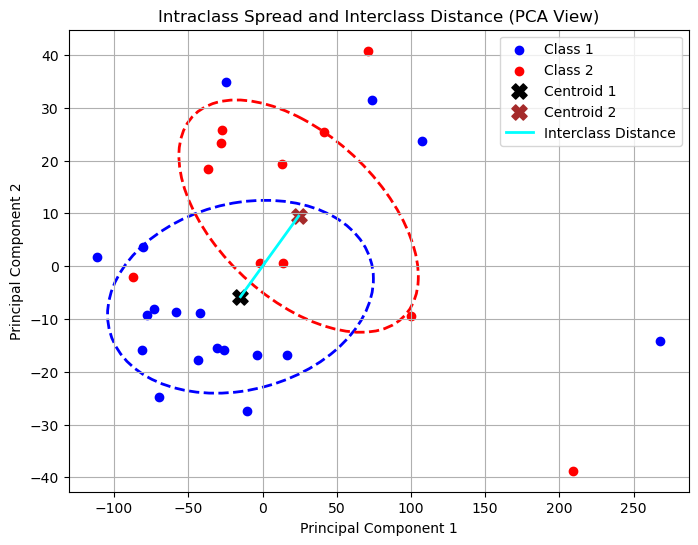

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# ---- Load classified dataset ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Ensure 'class' is int
df['class'] = df['class'].astype(int)

# ---- Features & classes ----
feature_cols = ["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]
classes = np.sort(df['class'].unique())

# ---- Compute centroids & std for each class ----
print("\nClass-wise Mean and Std Deviation:")
class_stats = {}
for cls in classes:
    data_cls = df[df['class'] == cls][feature_cols].values
    mean_vec = np.mean(data_cls, axis=0)
    std_vec = np.std(data_cls, axis=0)
    class_stats[cls] = {'mean': mean_vec, 'std': std_vec}
    print(f"\nClass {cls}:")
    print(f"  Mean Vector       : {mean_vec}")
    print(f"  Std Deviation     : {std_vec}")

# ---- Pick two classes for distance and visualization ----
class1, class2 = classes[0], classes[1]
centroid1 = class_stats[class1]['mean']
centroid2 = class_stats[class2]['mean']
euclidean_distance = np.linalg.norm(centroid1 - centroid2)
print("\n" + "-" * 80)
print(f"Euclidean Distance between Class {class1} and Class {class2}: {euclidean_distance:.4f}")
print("-" * 80)

# ---- PCA for visualization (reduce 5D to 2D) ----
X = df[df['class'].isin([class1, class2])][feature_cols].values
y = df[df['class'].isin([class1, class2])]['class'].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split data by class
X_c1 = X_pca[y == class1]
X_c2 = X_pca[y == class2]

# Compute centroids in PCA space
centroid_c1_pca = np.mean(X_c1, axis=0)
centroid_c2_pca = np.mean(X_c2, axis=0)

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.scatter(X_c1[:, 0], X_c1[:, 1], color='blue', label=f'Class {class1}')
plt.scatter(X_c2[:, 0], X_c2[:, 1], color='red', label=f'Class {class2}')

# Mark centroids
plt.scatter(*centroid_c1_pca, color='black', s=120, marker='X', label=f'Centroid {class1}')
plt.scatter(*centroid_c2_pca, color='brown', s=120, marker='X', label=f'Centroid {class2}')

# Draw ellipses for spread
def draw_ellipse(center, cov_matrix, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor=color, fc='None', lw=2, linestyle='--')
    plt.gca().add_patch(ellipse)

draw_ellipse(centroid_c1_pca, np.cov(X_c1.T), 'blue')
draw_ellipse(centroid_c2_pca, np.cov(X_c2.T), 'red')

# Draw interclass distance line
plt.plot([centroid_c1_pca[0], centroid_c2_pca[0]], [centroid_c1_pca[1], centroid_c2_pca[1]], 
         color='cyan', linewidth=2, label='Interclass Distance')

plt.title('Intraclass Spread and Interclass Distance (PCA View)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


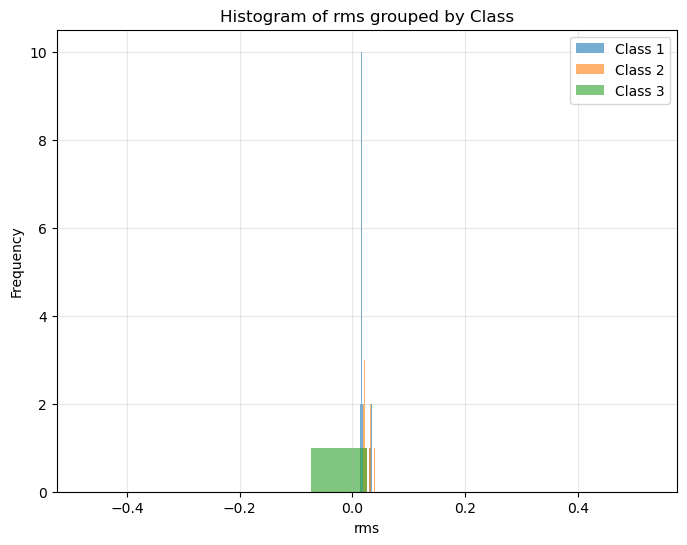

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Load classified CSV ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Choose feature for histogram (you can change to 'pitch_std' or others)
feature = 'rms'

# ---- Plot histogram for each class ----
plt.figure(figsize=(8, 6))
classes = sorted(df['class'].unique())
for cls in classes:
    data_cls = df[df['class'] == cls][feature]
    plt.hist(data_cls, bins=10, alpha=0.6, label=f'Class {cls}')

plt.title(f'Histogram of {feature} grouped by Class')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


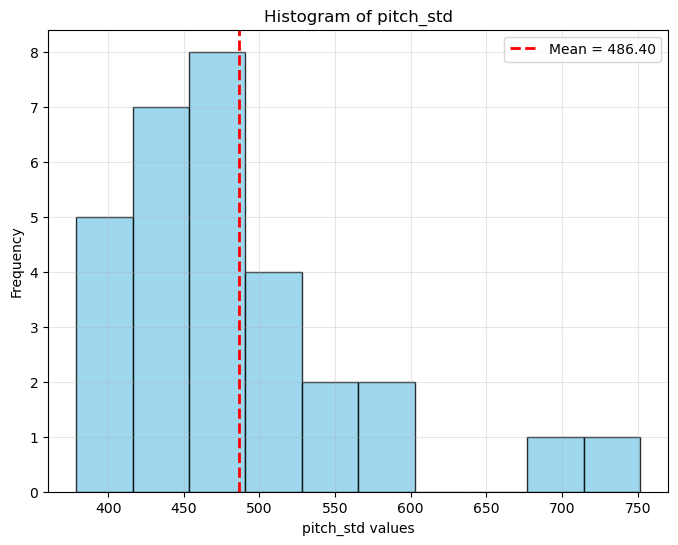

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Load classified CSV ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# ---- Feature for histogram ----
feature = 'pitch_std'
data = df[feature]

# ---- Calculate mean ----
mean_value = data.mean()

# ---- Plot histogram ----
plt.figure(figsize=(8, 6))
plt.hist(data, bins=10, color='skyblue', edgecolor='black', alpha=0.8)

# Mean line
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_value:.2f}')

# Titles and labels
plt.title(f'Histogram of {feature}')
plt.xlabel(f'{feature} values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



================ Minkowski Distance for r = 1 to 10 ================

Minkowski Distance (r=1): 259.6390
Minkowski Distance (r=2): 219.9553
Minkowski Distance (r=3): 216.2566
Minkowski Distance (r=4): 215.7693
Minkowski Distance (r=5): 215.6969
Minkowski Distance (r=6): 215.6854
Minkowski Distance (r=7): 215.6835
Minkowski Distance (r=8): 215.6832
Minkowski Distance (r=9): 215.6831
Minkowski Distance (r=10): 215.6831


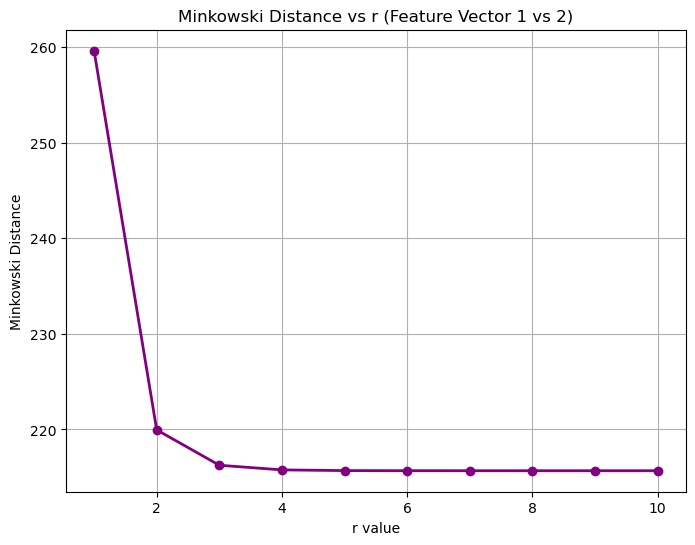

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Load dataset ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Select two feature vectors (first two rows for example)
vec1 = df.iloc[0][["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]].values
vec2 = df.iloc[1][["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]].values

# ---- Calculate Minkowski distance for r = 1 to 10 ----
r_values = range(1, 11)
distances = []

print("\n================ Minkowski Distance for r = 1 to 10 ================\n")
for r in r_values:
    dist = np.sum(np.abs(vec1 - vec2) ** r) ** (1 / r)
    distances.append(dist)
    print(f"Minkowski Distance (r={r}): {dist:.4f}")

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.plot(r_values, distances, marker='o', color='purple', linewidth=2)
plt.title('Minkowski Distance vs r (Feature Vector 1 vs 2)')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.grid(True)
plt.show()


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Remove classes with only 1 sample
class_counts = df['class'].value_counts()
df = df[df['class'].isin(class_counts[class_counts > 1].index)]

# Features and target
X = df[["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]]
y = df["class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Output in required format
print(f"\nTotal samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")

print("--- First 5 Training Labels ---")
print(y_train.head())

print("\n--- First 5 Test Labels ---")
print(y_test.head())



Total samples: 29
Training samples: 20
Testing samples: 9

--- First 5 Training Labels ---
22    2
2     1
20    1
0     1
15    1
Name: class, dtype: int64

--- First 5 Test Labels ---
10    1
23    2
3     2
21    1
19    1
Name: class, dtype: int64


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---- Load dataset ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Remove classes with only 1 sample (same as A4)
class_counts = df['class'].value_counts()
df = df[df['class'].isin(class_counts[class_counts > 1].index)]

# Features and target
X = df[["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]]
y = df["class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ---- Train kNN classifier (k=3) ----
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predictions
y_pred = knn.predict(X_test)

# ---- Evaluation ----
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("KNN Classifier Results")
print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


KNN Classifier Results
Accuracy on test set: 88.89%
Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92         6
           2       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9



In [27]:
from sklearn.metrics import accuracy_score

# Accuracy calculation (already trained knn from A5)
accuracy = accuracy_score(y_test, y_pred)

# Output in required format
print(f"KNN Classifier Accuracy: {accuracy * 100:.2f}%")


KNN Classifier Accuracy: 88.89%


In [28]:
# === Predictions for All Test Vectors ===
print("=== Predictions for All Test Vectors ===")
print("Predicted Labels:", list(y_pred))
print("Actual Labels   :", list(y_test.values))

# === Prediction for a Single Test Vector ===
single_index = 0  # You can change this index
single_vector = X_test.iloc[single_index].values.reshape(1, -1)
predicted_class = knn.predict(single_vector)[0]
actual_class = y_test.iloc[single_index]

print("\n=== Prediction for a Single Test Vector ===")
print(f"Test Vector Index: {single_index}")
print(f"Predicted Class : {predicted_class}")
print(f"Actual Class    : {actual_class}")


=== Predictions for All Test Vectors ===
Predicted Labels: [1, 2, 1, 1, 1, 1, 2, 1, 1]
Actual Labels   : [1, 2, 2, 1, 1, 1, 2, 1, 1]

=== Prediction for a Single Test Vector ===
Test Vector Index: 0
Predicted Class : 1
Actual Class    : 1


C:\Users\Rithvik\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


=== Accuracy for Different k Values ===
k = 1, Accuracy = 77.78%
k = 2, Accuracy = 77.78%
k = 3, Accuracy = 88.89%
k = 4, Accuracy = 77.78%
k = 5, Accuracy = 88.89%
k = 6, Accuracy = 88.89%
k = 7, Accuracy = 55.56%
k = 8, Accuracy = 77.78%
k = 9, Accuracy = 66.67%
k = 10, Accuracy = 66.67%
k = 11, Accuracy = 77.78%


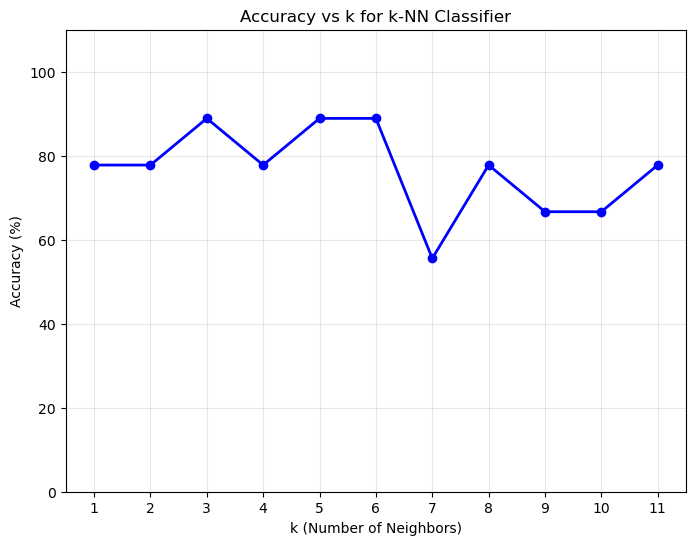

In [30]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Convert DataFrames to NumPy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Range of k values
k_values = range(1, 12)
accuracies = []

print("=== Accuracy for Different k Values ===")
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_np, y_train_np)
    y_pred_temp = knn_temp.predict(X_test_np)
    acc = accuracy_score(y_test_np, y_pred_temp)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc * 100:.2f}%")

# Plot Accuracy vs k
plt.figure(figsize=(8, 6))
plt.plot(k_values, [a * 100 for a in accuracies], marker='o', color='blue', linewidth=2)
plt.title('Accuracy vs k for k-NN Classifier')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy (%)')
plt.xticks(k_values)
plt.ylim(0, 110)
plt.grid(alpha=0.3)
plt.show()


Training Classification Report ===
              precision    recall  f1-score   support

           1     0.8333    0.8333    0.8333        12
           2     0.7500    0.7500    0.7500         8

    accuracy                         0.8000        20
   macro avg     0.7917    0.7917    0.7917        20
weighted avg     0.8000    0.8000    0.8000        20


Testing Classification Report ===
              precision    recall  f1-score   support

           1     0.8571    1.0000    0.9231         6
           2     1.0000    0.6667    0.8000         3

    accuracy                         0.8889         9
   macro avg     0.9286    0.8333    0.8615         9
weighted avg     0.9048    0.8889    0.8821         9

Train Accuracy: 0.8000
Test Accuracy: 0.8889
>>> Model is likely UNDERFITTING


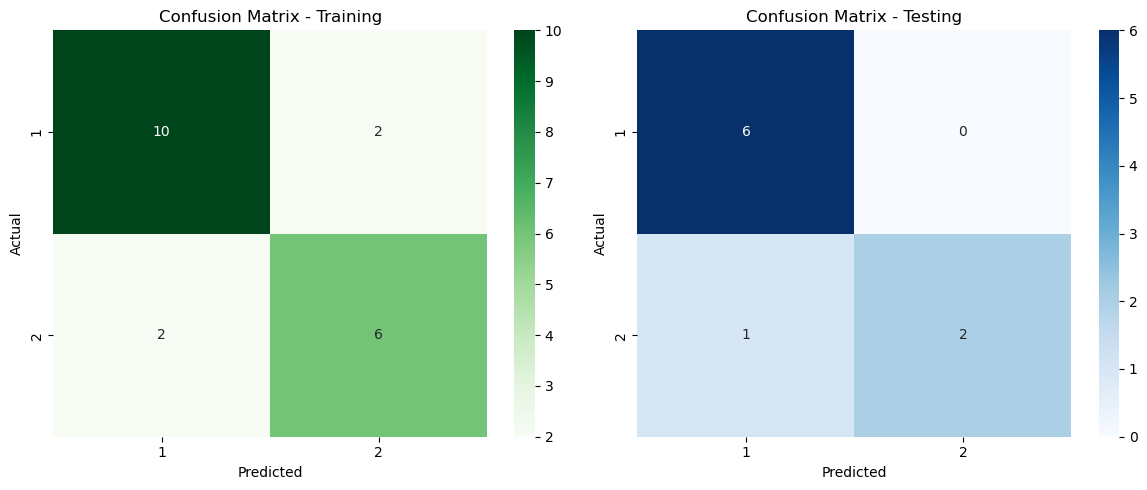

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Load dataset ----
csv_path = r"D:\semester 5\machine learning\project\VivaData_Set2_23012\confidence_features(1)_classified.csv"
df = pd.read_csv(csv_path)

# Remove classes with only 1 sample
class_counts = df['class'].value_counts()
df = df[df['class'].isin(class_counts[class_counts > 1].index)]

# Features and target
X = df[["mfcc1", "rms", "zcr", "pitch_std", "silence_pc"]].to_numpy()
y = df["class"].to_numpy()

# ---- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ---- Train KNN (k=3) ----
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# ---- Accuracy ----
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# ---- Confusion Matrices ----
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# ---- Print Reports ----
print("Training Classification Report ===")
print(classification_report(y_train, y_train_pred, digits=4))

print("\nTesting Classification Report ===")
print(classification_report(y_test, y_test_pred, digits=4))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# ---- Model Fit Analysis ----
if abs(train_acc - test_acc) < 0.05 and train_acc > 0.8:
    print(">>> Model is likely REGULAR FIT")
elif train_acc < 0.9 and test_acc >= train_acc:
    print(">>> Model is likely UNDERFITTING")
else:
    print(">>> Model may be OVERFITTING")

# ---- Plot Confusion Matrices ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(set(y)), yticklabels=sorted(set(y)), ax=axes[0])
axes[0].set_title('Confusion Matrix - Training')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y)), yticklabels=sorted(set(y)), ax=axes[1])
axes[1].set_title('Confusion Matrix - Testing')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


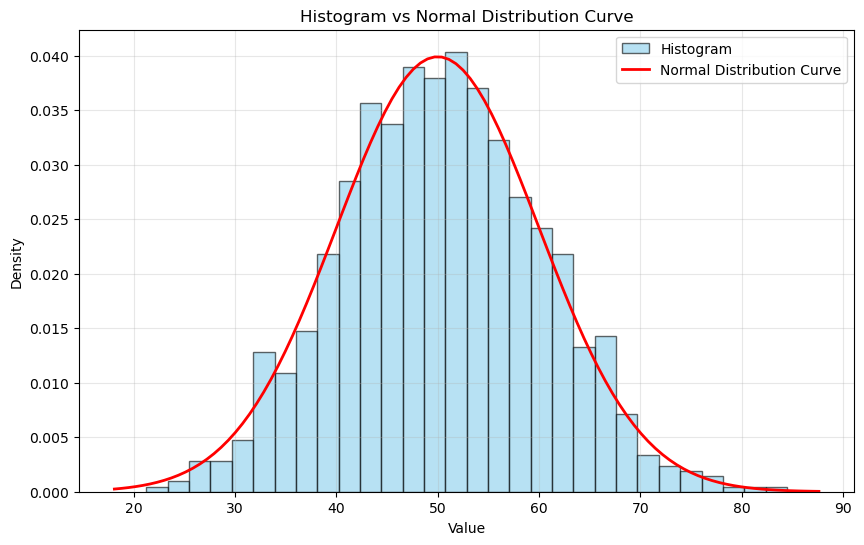

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---- Step 1: Generate Normal Distribution Data ----
mean = 50
std_dev = 10
size = 1000

data = np.random.normal(mean, std_dev, size)

# ---- Step 2: Plot Histogram ----
plt.figure(figsize=(10, 6))

# Histogram
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

# ---- Step 3: Normal Distribution Curve ----
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)

plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Curve')

# Labels and Title
plt.title('Histogram vs Normal Distribution Curve')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Metrics to test
metrics = [
    ('euclidean', {}),
    ('manhattan', {}),
    ('minkowski', {'p': 3}),
    ('chebyshev', {})
]

print("=== Accuracy with Different Distance Metrics ===")
for metric, params in metrics:
    knn = KNeighborsClassifier(n_neighbors=3, metric=metric, **params)
    knn.fit(X_train, y_train)
    y_pred_metric = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_metric)
    print(f"Metric: {metric}, Params: {params}, Accuracy: {acc * 100:.2f}%")


=== Accuracy with Different Distance Metrics ===
Metric: euclidean, Params: {}, Accuracy: 88.89%
Metric: manhattan, Params: {}, Accuracy: 88.89%
Metric: minkowski, Params: {'p': 3}, Accuracy: 77.78%
Metric: chebyshev, Params: {}, Accuracy: 77.78%


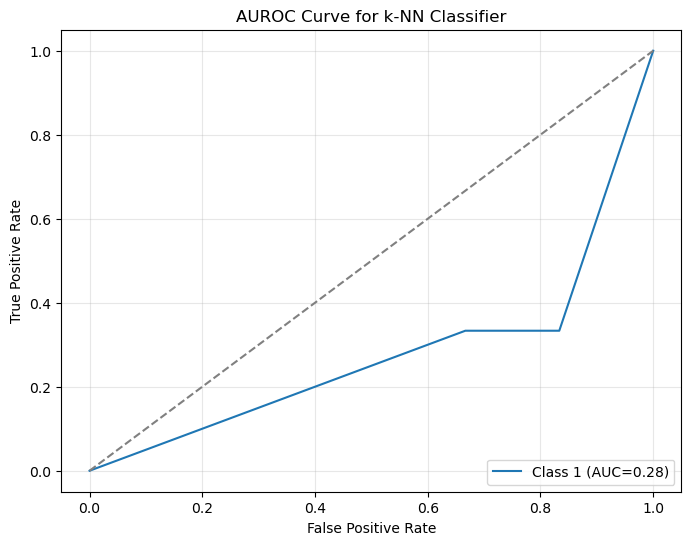

Macro-Average AUC: 0.2778


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ---- Get classes present in y_test ----
present_classes = sorted(set(y_test))

# ---- Binarize y_test ----
y_test_bin = label_binarize(y_test, classes=present_classes)
y_score = knn.predict_proba(X_test)

# ---- Compute ROC curve & AUC for each class ----
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
for i in range(y_test_bin.shape[1]):  # Loop through actual number of columns
    if np.sum(y_test_bin[:, i]) > 0:
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_dict[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# ---- Compute Macro-Average ROC (if multiple classes) ----
if len(fpr_dict) > 1:
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in fpr_dict]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr_dict:
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(fpr_dict)
    macro_auc = np.mean(list(auc_dict.values()))
else:
    macro_auc = list(auc_dict.values())[0]  # Only one class present

# ---- Plot AUROC ----
plt.figure(figsize=(8, 6))

for i in fpr_dict:
    plt.plot(fpr_dict[i], tpr_dict[i], label=f'Class {present_classes[i]} (AUC={auc_dict[i]:.2f})')

if len(fpr_dict) > 1:
    plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', linewidth=2,
             label=f'Macro Avg (AUC={macro_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('AUROC Curve for k-NN Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"Macro-Average AUC: {macro_auc:.4f}")
